In [10]:
%matplotlib inline

In [11]:
import gymnasium as gym
import numpy as np

class CustomCartPole(gym.Env):
    def __init__(self, alpha=2.0, beta=0.3, gamma=0.25, kappa=0.01, control_weight=0.001, angle_bonus=5):
        super().__init__()
        
        # Base environment setup
        self.env = gym.make('CartPole-v1')
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        
        # Reward parameters
        self.alpha = alpha      # Angle weight
        self.beta = beta        # Angular velocity weight  
        self.gamma = gamma      # Position weight
        self.kappa = kappa      # Velocity weight
        self.control_weight = control_weight  # Action penalty
        self.angle_bonus = angle_bonus        # Bonus when |θ| < 5°
        self.angle_threshold = np.deg2rad(5)  # ~0.087 radians
        
        # Tracking
        self.last_action = 0
        self.target = np.array([0, 0, 0, 0])  # [x, ẋ, θ, θ̇]
        
    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)
        x, x_dot, theta, theta_dot = obs - self.target
        
        if abs(theta) <= self.angle_threshold:
            # Give bonus if within angle threshold
            reward = self.angle_bonus
        else:
            # Negative quadratic costs otherwise
            reward = -(
                self.alpha * theta**2 +
                self.beta * theta_dot**2 +
                self.gamma * x**2 +
                self.kappa * x_dot**2 +
                self.control_weight * self.last_action**2
            )
        
        self.last_action = action
        return obs, reward, terminated or truncated, False, info
    
    def reset(self, **kwargs):
        self.last_action = 0
        return self.env.reset(**kwargs)
    
    # Preserve original rendering
    render = lambda self, **kwargs: self.env.render(**kwargs)
    close = lambda self: self.env.close()

In [12]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# env = gym.make("CartPole-v1")
env = CustomCartPole(alpha=2.0, beta=0.3, gamma=0.25, kappa=0.01, control_weight=0.001, angle_bonus=5)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [13]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [14]:
# import numpy as np
# Transition = namedtuple('Transition',
#                         ('state', 'action', 'next_state', 'reward'))

# class ReplayMemory(object):

#     def __init__(self, capacity):
#         self.memory = deque([], maxlen=capacity)
#         self.recent_rewards = deque([], maxlen=100)

#     def push(self, *args):
#         """Save a transition if it meets the reward criteria"""
#         transition = Transition(*args)
#         reward = transition.reward.item()

#         self.recent_rewards.append(reward)

#         if len(self.recent_rewards) < 100:
#             self.memory.append(transition)
#         else:
#             # avg_reward = sum(self.recent_rewards) / len(self.recent_rewards)
#             # max_reward = max(self.recent_rewards)
#             # median_reward = np.median(self.recent_rewards)
#             ms_reward = np.mean(np.array(self.recent_rewards)**2)
#             if reward > ms_reward:
#                 self.memory.append(transition)

#     def sample(self, batch_size):
#         return random.sample(self.memory, batch_size)

#     def __len__(self):
#         return len(self.memory)

In [15]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [16]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4


n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [17]:
def optimise_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [18]:
print(torch.cuda.is_available())

True


Complete


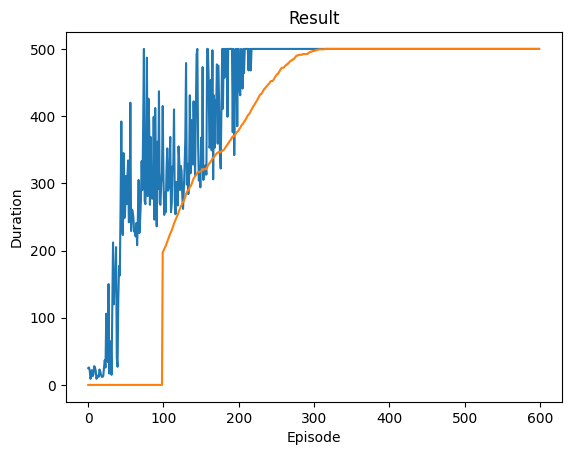

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimise_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()